<a name="top" id="top"></a>

<div align="center">
    <h1>Graver Augmentation Multiseed Algorithm</h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Universities Space Research Association</i>
    <br>
    <i>NASA QuAIL</i>
    <br>
    <br>
    <a href="https://github.com/pedromxavier">Pedro Maciel Xavier</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Computer Science &amp; Systems Engineering Program, Federal University of Rio de Janeiro</i>
    <br>
    <i>PSR Energy Consulting &amp; Analytics</i>
    <br>
    <br>
    <a href="https://github.com/murraybj">Benjamin J. L. Murray</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Undergraduate Research Assistant</i>
    <br>
    <br>
    <a href="https://colab.research.google.com/github/JuliaQUBO/QUBONotebooks/blob/main/notebooks_py/3-GAMA_python.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

This notebook makes simple computations of Graver basis. Because of the complexity of these computation, we suggest that for more complicated problems you install the excellent **[4ti2](https://4ti2.github.io/)** software, an open-source implementation of several routines useful for the study of integer programming through algebraic geometry. It can be used as a stand-alone library and call it from C++ or from Python. In python, there are two ways of accessing it, either through **[Sage](https://www.sagemath.org/)** (which is an open-source mathematics software) or directly compiling it and installing a thing called a **[Python wrapper](https://github.com/alfsan/Py4ti2)**

## Introduction to GAMA

The Graver Augmentation Multiseed Algorithm (GAMA) was proposed by [two](https://arxiv.org/abs/1902.04215) [papers](https://arxiv.org/abs/1907.10930) by Alghassi, Dridi, and Tayur from the CMU Quantum Computing group.
The three main ingredients of this algorithm, designed to solve integer programs with linear constraints and nonlinear objective, are:

- Computing the Graver basis (or a subset of it) of an integer program.
- Performing an augmentation.
- Given that only for certain objective functions, the Graver augmentation is guaranteed to find a globally optimal solution, the algorithm is initialized in several points.

This algorithm can be adapted to take advantage of Quantum Computers by leveraging them as black-box Ising/QUBO problem solvers.
In particular, obtaining several feasible solution points for the augmentation and computing the Kernel of the constraint matrix can be posed as QUBO problems.
After obtaining these solutions, other routines implemented in classical computers are used to solve the optimization problems, making this a hybrid quantum-classical algorithm.

### Introduction to Graver basis computation

A Graver basis is defined as

$$
\mathcal{G}(\mathbf{A}) = \bigcup_{j} \mathcal{H}_{j}(\mathbf{A})
$$

where $\mathcal{H}_{j}(\mathbf{A})$ are the minimal Hilbert basis of $\mathbf{A}$ in each orthant.

Equivalently we can define the Graver basis as the $\sqsubseteq$-minimal set of a lattice

$$
\mathcal{L}(\mathbf{A}) = \left\lbrace{}{\mathbf{x} : \mathbf{A} \mathbf{x} = 0, \mathbf{x} \in \mathbb{Z}^{n}}\right\rbrace{} \setminus \left\lbrace{}{0}\right\rbrace{} = \ker A \cap \mathbb{Z}^{n}
$$

where the partial ordering $\mathbf{x} \sqsubseteq \mathbf{y}$ holds whenever $x_i y_i \geq 0$ and $\left\vert x_i \right\vert \leq \left\vert y_i \right\vert$ for all $i$.

Here we won't interact with the Quantum Computer.
However, we will obtain the Graver basis of a problem using package 4ti2.
This notebook studies the behavior of the search algorithm in the case that we only have available a subset of the Graver basis.

In [14]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# if not IN_COLAB:
#   from Py4ti2int32 import *


In [15]:
from sympy import *
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import itertools
import random
import time

In [16]:
# Define rules to choose augmentation element, either the best one (argmin) or the first one that is found
def argmin(iterable):
    return min(enumerate(iterable), key=lambda x: x[1])

def greedy(iterable):
    for i, val in enumerate(iterable):
        if val[1] != 0:
            return i, val
    else:
        return i, val

In [17]:
# Bisection rules for finding best step size
def bisection(g: np.ndarray, fun: Callable, x: np.ndarray, x_lo: np.ndarray = None, x_up: np.ndarray = None, laststep: np.ndarray = None) -> (float, int):
    if np.array_equal(g, laststep):
        return (fun(x), 0)
    if x_lo is None:
        x_lo = np.zeros_like(x)
    if x_up is None:
        x_up = np.ones_like(x)*max(x)*2

    u = max(x_up) - min(x_lo)
    l = -(max(x_up) - min(x_lo))
    for i, gi in enumerate(g):
        if gi >= 1:
            if np.floor((x_up[i] - x[i]) / gi) < u:
                u = int(np.floor((x_up[i] - x[i]) / gi))
            if np.ceil((x_lo[i] - x[i]) / gi) > l:
                l = int(np.ceil((x_lo[i] - x[i]) / gi))
        elif gi <= -1:
            if np.ceil((x_up[i] - x[i]) / gi) > l:
                l = int(np.ceil((x_up[i] - x[i]) / gi))
            if np.floor((x_lo[i] - x[i]) / gi) < u:
                u = int(np.floor((x_lo[i] - x[i]) / gi))
    alpha = u

    while u - l > 1:
        if fun(x + l*g) < fun(x + u*g):
            alpha = l
        else:
            alpha = u
        p1 = int(np.floor((l+u)/2) - 1)
        p2 = int(np.floor((l+u)/2))
        p3 = int(np.floor((l+u)/2) + 1)
        if fun(x + p1*g) < fun(x + p2*g):
            u = int(np.floor((l+u)/2))
        elif fun(x + p3*g) < fun(x + p2*g):
            l = int(np.floor((l+u)/2) + 1)
        else:
            alpha = p2
            break

    if fun(x + l*g) < fun(x + u*g) and fun(x + l*g) < fun(x + alpha*g):
        alpha = l
    elif fun(x + u*g) < fun(x + alpha*g):
        alpha = u

    return (fun(x + alpha*g), alpha)

In [18]:
# We can just have a single step move (works well with greedy approach)
def single_move(g: np.ndarray, fun: Callable, x: np.ndarray, x_lo: np.ndarray = None, x_up: np.ndarray = None, laststep: np.ndarray = None) -> (float, int):
    if x_lo is None:
        x_lo = np.zeros_like(x)
    if x_up is None:
        x_up = np.ones_like(x)*max(x)*2

    alpha = 0

    if (x + g <= x_up).all() and (x + g >= x_lo).all():
        if fun(x + g) < fun(x):
            alpha = 1
    elif (x - g <= x_up).all() and (x - g >= x_lo).all():
        if fun(x - g) < fun(x) and fun(x - g) < fun(x + g):
            alpha = -1

    return (fun(x + alpha*g), alpha)

We will be solving EXAMPLE 4 in the code, which corresponds to the Case 2 in the original GAMA paper. The problem is derived from finance and deals with the maximization of expected returns on an investments and the minimization of the variance.
$$
\min -\sum_{i=1}^n \mu_ix_i + \sqrt{\frac{1-\epsilon}{\epsilon}\sum_{i=1}^n \sigma_i^2 x_i^2} \\
s.t. Ax = b, x \in \{-2,-1,-0,1,2 \}^n
$$
This particular instance of convex INLP has $n=25, \epsilon=0.01, \mu_i = \text{Rand}[0,1], \sigma_i = \text{Rand}[0,\mu_i]$.
The matrix $A$ is a matrix with 1's and 0's and the $b$ vector is half of the sum of the rows of $A$, in this case $b = (9,8,7,5,5)^\top$.

The Graver basis of this matrix $A$ has 29789 elements, which in a standard laptop using 4ti2 takes ~5 seeconds to compute. If you are in Colab you will import it from a file.

### Example

Let

$$
A = \begin{bmatrix}
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 0 & 1 & 0 & 1 & 0 & 1 & 0 & 1 & 1 & 1 & 0 & 1 & 0 & 1 & 0 \\
1 & 1 & 1 & 1 & 0 & 1 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 1 & 0 & 0 & 0 & 1 & 0 & 1 & 0 & 1 & 1 & 0 & 1 & 1 & 0 & 1 & 1 & 0 & 0 & 1 & 0 & 0 & 1 & 1 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 1 & 1 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 0 & 1 & 0 \\
\end{bmatrix}
$$

This particular instance of convex INLP has $m = 5$, $n = 25$, $\varepsilon = 0.01$, $\mu_{i} = \textrm{rand}[0, 1]$, $\sigma_{i} = \textrm{rand}[0, \mu_{i}]$.
$A \in \mathbb{B}^{m \times n}$ and each $b_{j}$ is half the sum of the $j$-th row of $A$.
In this example, $\mathbf{b} = \left({9, 8, 7, 5, 5}\right)'$.

In [19]:
A = np.array([[1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,0,1,0,1,0],
            [1,1,1,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,1,1,1,1,1],
            [0,1,0,0,0,1,0,1,0,1,1,0,1,1,0,1,1,0,0,1,0,0,1,1,1],
            [0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0],
            [0,1,1,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0]])
b = np.array([[9], [8], [7], [5], [5]])

# Objective is quadratic expression
x0 = np.array([1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -2,
            1, 0, -1, 0, 1, -1, 1, -2, -2, 1, 1, 1])
x_lo = -2*np.ones_like(x0)
x_up = 2*np.ones_like(x0)
# Parameters of objective function
epsilon = 0.01
mu = np.random.rand(len(x0))
sigma = np.multiply(np.random.rand(len(x0)),mu)
if IN_COLAB:
    print("The Graver basis has 29789 elements in this case")
    !wget -N -q "https://github.com/JuliaQUBO/QUBONotebooks/raw/main/notebooks_py/graver.npy"
    r = np.load(r'/content/graver.npy')
    r = np.array(r)
else:
    r = np.load(r'graver.npy')
    r = np.array(r)

In [20]:
# Objective function definition
def f(x):
    return -np.dot(mu, x) + np.sqrt(((1-epsilon)/epsilon)*np.dot(sigma**2, x**2))

# Constraints definition
def const(x):
    return np.array_equiv(np.dot(A,x),b.T) or np.array_equiv(np.dot(A,x),b)


In [21]:
def augmentation(grav = r, func = f, x = x0, x_lo = x_lo, x_up = x_up, OPTION: int = 1, VERBOSE: bool = True, itermax: int = 1000) -> (int, float, np.ndarray):
    # Let's perform the augmentation and return the number of steps and the best solution
    # OPTION = 1 # Best augmentation, select using bisection rule
    # OPTION = 2 # Greedy augmentation, select using bisection rule
    # OPTION = 3 # Greedy augmentation, select using first found

    dist = 1
    gprev = None
    k = 1
    if VERBOSE:
        print("Initial point:", x)
        print("Objective function:",func(x))
    while dist != 0 and k < itermax:
        if OPTION == 1:
            g1, (obj, dist) = argmin(
                bisection(g=e, fun=func, x=x, laststep=gprev, x_lo=x_lo, x_up=x_up) for e in grav)
        elif OPTION == 2:
            g1, (obj, dist) = greedy(
                bisection(g=e, fun=func, x=x, laststep=gprev, x_lo=x_lo, x_up=x_up) for e in grav)
        elif OPTION == 3:    
            g1, (obj, dist) = greedy(
                single_move(g=e, fun=func, x=x, x_lo=x_lo, x_up=x_up) for e in grav)
        else:
            print("Option not implemented")
            break
        x = x + grav[g1]*dist
        gprev = grav[g1]
        if VERBOSE:
            print("Iteration ", k)
            print(g1, (obj, dist))
            print("Augmentation direction:", gprev)
            print("Distanced moved:", dist)
            print("Step taken:", grav[g1]*dist)
            print("Objective function:", obj)
            print(func(x))
            print("Current point:", x)
            print("Are constraints satisfied?", const(x))
        else:
            if k%50 == 0:
                print(k)
                print(obj)
        k += 1
    return(k,obj,x)

First, we will prove our augmentation strategies, either best or greedy, and for greedy, either computing the best step or a single move. In the order that was mentioned, the augmentation will take more iterations, but each one of the augmentation steps or iterations is going to be cheaper.

In [22]:
print('Best-augmentation: Choosing among the best step that each element of G can do (via bisection), the one that reduces the most the objective')
start = time.process_time()
iter,f_obj,xf = augmentation(func = f, OPTION=1,VERBOSE=False)
print(time.process_time() - start, 'seconds')
print(iter, 'iterations')
print('solution:',f_obj,xf)

print('Greedy-best-augmentation: Choosing among the best step that each element of G can do (via bisection), the first one encountered that reduces the objective')
start = time.process_time()
iter,f_obj,xf = augmentation(func = f, OPTION=2,VERBOSE=False)
print(time.process_time() - start, 'seconds')
print(iter, 'iterations')
print('solution:',f_obj,xf)

print('Greedy-augmentation: Choosing among the first element of G that with a single step reduces the objective')
start = time.process_time()
iter,f_obj,xf = augmentation(func = f, OPTION=3,VERBOSE=False)
print(time.process_time() - start, 'seconds')
print(iter, 'iterations')
print('solution:',f_obj,xf)

Best-augmentation: Choosing among the best step that each element of G can do (via bisection), the one that reduces the most the objective
28.561966125 seconds
9 iterations
solution: -4.372837346323999 [ 0  1  0  0  0  2  0  0  1  2  1 -1  0  0  2  1  0  2  1  0  0  0  0  0
  0]
Greedy-best-augmentation: Choosing among the best step that each element of G can do (via bisection), the first one encountered that reduces the objective
4.014503152 seconds
35 iterations
solution: -4.372837346323999 [ 0  1  0  0  0  2  0  0  1  2  1 -1  0  0  2  1  0  2  1  0  0  0  0  0
  0]
Greedy-augmentation: Choosing among the first element of G that with a single step reduces the objective
1.2133407050000002 seconds
31 iterations
solution: -3.7826122452992683 [ 1  1  0  0  0  2  0  0  1  2  1 -1  0  0  2  1  0  1  1  0  0  0  0  0
  0]


Now we can highlight another feature of the algorithm, computing starting feasible solutions. For this case we formulate a QUBO and solve it via annealing.
In this particular case, we will not encode the integer variables and will only look feasible solutions in the case that $x \in \{0,1 \}^n$

In [23]:
# Let's install with dimod and neal
if IN_COLAB:
    !pip install dimod
    !pip install dwave-neal
import dimod
import neal

In [24]:
def get_feasible(A, b, sampler, samples=20):

    AA = np.dot(A.T, A)
    h = -2.0*np.dot(b.T, A)
    Q = AA + np.diag(h[0])
    offset = np.dot(b.T, b) + 0.0

    # Define Binary Quadratic Model
    bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(mat=Q, offset=offset)

    response = sampler.sample(bqm, num_reads=samples)

    response = response.aggregate()

    filter_idx = [i for i, e in enumerate(response.record.energy) if e == 0.0]

    feas_sols = response.record.sample[filter_idx]

    return feas_sols

### Problem statement

We pose the Ising problem as the following optimization problem:

$$
\min_{s \in \{ \pm 1 \}^n} H(s) = \min_{s \in \{ \pm 1 \}^n} \sum_{(i, j) \in E(G)} J_{i,j}s_is_j + \sum_{i \in V(G)} h_is_i + \beta
$$

where we optimize over spins $s \in \{ \pm 1 \}^n$, on a constrained graph $G(V,E)$, where the quadratic coefficients are $J_{i,j}$ and the linear coefficients are $h_i$.
We also include an arbitrary offset of the Ising model $\beta$.

We will use simulated annealing to solve this QUBO. In this case we want a broad sample of different feasible solutions, so solving this QUBO via MIP is not a great idea.

In [25]:
simAnnSampler = neal.SimulatedAnnealingSampler()

In [26]:
feas_sols = get_feasible(A, b, sampler=simAnnSampler, samples = 20)
print(len(feas_sols), ' feasible solutions found.')

20  feasible solutions found.


/tmp/ipykernel_148001/1613598710.py:9: DeprecationWarning: BQM.from_numpy_matrix(M) is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use BQM(M, "BINARY") instead.
  bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(mat=Q, offset=offset)


We take 20 samples using simulated annealing and notice that most (if not all of them) are feasible and different. Let's now apply the augmentation procedure to each one of them and record the final objective and the number of iterations it takes. Here we will use the 3rd augmentation strategy (Greedy) because of runtime.

In [27]:
init_obj = np.zeros((len(feas_sols),1))
iters_full = np.zeros((len(feas_sols),1))
final_obj_full = np.zeros((len(feas_sols),1))
times_full = np.zeros((len(feas_sols),1))
for i,sol in enumerate(feas_sols):
    if not const(sol):
        print("Infeasible")
        pass
    init_obj[i] = f(sol)
    start = time.process_time()
    iter, f_obj, xf = augmentation(grav = r, func = f, x = sol, OPTION=3,VERBOSE=False)
    times_full[i] = time.process_time() - start
    iters_full[i] = iter
    final_obj_full[i] = f_obj

We record the initial objective function, the one after doing the augmentation, and the number of augmentation steps.

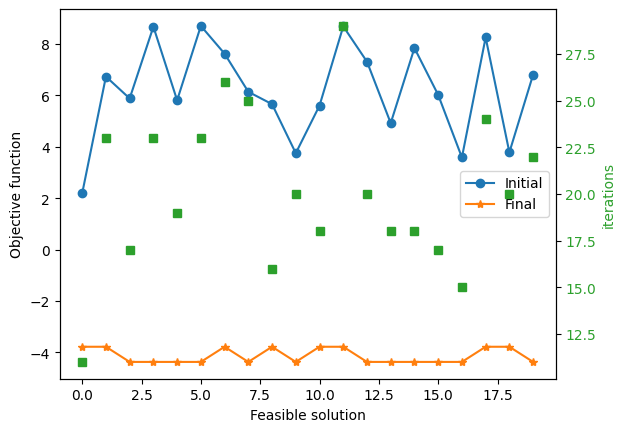

In [28]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(init_obj, marker='o', ls='-', label='Initial')
ax1.plot(final_obj_full, marker='*', ls='-', label='Final')
ax1.set_ylabel('Objective function')
ax1.set_xlabel('Feasible solution')


color = 'tab:green'
ax2.set_ylabel('iterations', color=color)
ax2.plot(iters_full, color=color, marker='s', ls='')
ax2.tick_params(axis='y', labelcolor=color)
ax1.legend()

Notice that we reach the globally optimal solution regardless of the initial point and that even if the initial objective was closer to the optimal objective function, it might take more iterations to reach the optimum.

Now let's try an extreme case, where we only have 10 of the elements of the Graver basis.

In [29]:
n_draws = 10  # for 10 random indices
index = np.random.choice(r.shape[0], n_draws, replace=False) 

iters_few = np.zeros((len(feas_sols),1))
final_obj_few = np.zeros((len(feas_sols),1))
times_few = np.zeros((len(feas_sols),1))
for i, sol in enumerate(feas_sols):
    if not const(sol):
        print("Infeasible")
        pass
    start = time.process_time()
    iter, f_obj, xf = augmentation(grav = r[index], x = sol, func = f, OPTION=3,VERBOSE=False)
    times_few[i] = time.process_time() - start
    iters_few[i] = iter
    final_obj_few[i] = f_obj

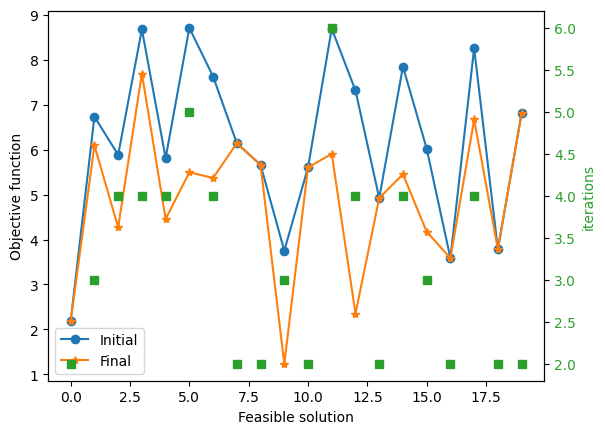

In [30]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(init_obj, marker='o', ls='-', label='Initial')
ax1.plot(final_obj_few, marker='*', ls='-', label='Final')
ax1.set_ylabel('Objective function')
ax1.set_xlabel('Feasible solution')


color = 'tab:green'
ax2.set_ylabel('iterations', color=color)
ax2.plot(iters_few, color=color, marker='s', ls='')
ax2.tick_params(axis='y', labelcolor=color)
ax1.legend()

Here we can barely improve the objective and can only perform a few iterations before we cannot improve the solution. But if we compare the runtimes in both cases, we find that...

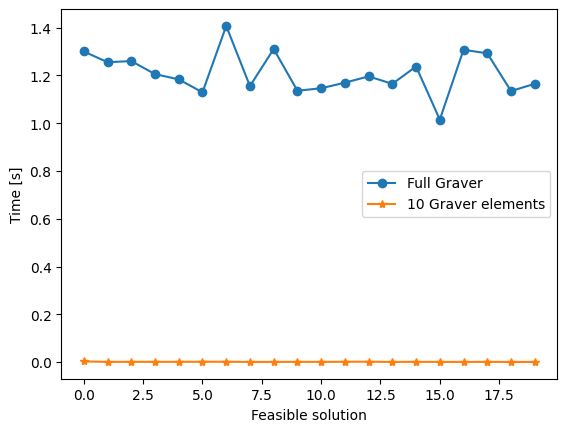

In [31]:
fig, ax1 = plt.subplots()

ax1.plot(times_full, marker='o', ls='-', label='Full Graver')
ax1.plot(times_few, marker='*', ls='-', label='10 Graver elements')
ax1.set_ylabel('Time [s]')
ax1.set_xlabel('Feasible solution')
plt.legend()

...the time to do augmentation only having 10 choices is minimal. We can search for a sweet spot in between, with good solutions and little time.

In [32]:
N = 10 # Discretization of the fractions of Graver considered
iters = np.zeros((len(feas_sols),N-1))
final_obj = np.zeros((len(feas_sols),N-1))
times = np.zeros((len(feas_sols),N-1))
for j in range(1,N):

    n_draws = r.shape[0]//N*j  # for 10 random indices
    index = np.random.choice(r.shape[0], n_draws, replace=False) 

    for i, sol in enumerate(feas_sols):
        if not const(sol):
            print("Infeasible")
            pass
        start = time.process_time()
        iter, f_obj, xf = augmentation(grav = r[index], x = sol, func = f, OPTION=3,VERBOSE=False)
        times[i,j-1] = time.process_time() - start
        iters[i,j-1] = iter
        final_obj[i,j-1] = f_obj

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(1, 0, 'initial'),
  Text(2, 0, '10 samples'),
  Text(3, 0, '0.1|G|'),
  Text(4, 0, '0.2|G|'),
  Text(5, 0, '0.3|G|'),
  Text(6, 0, '0.4|G|'),
  Text(7, 0, '0.5|G|'),
  Text(8, 0, '0.6|G|'),
  Text(9, 0, '0.7|G|'),
  Text(10, 0, '0.8|G|'),
  Text(11, 0, '0.9|G|'),
  Text(12, 0, '|G|')])

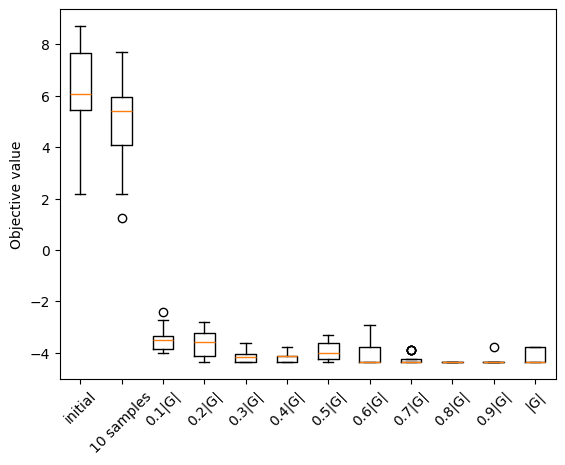

In [33]:
fig, ax1 = plt.subplots()
x_label = [str(int(100*i/N)/100) + '|G|' for i in range(1,N)]
x_label.insert(0,'10 samples')
x_label.append('|G|')
x_label_obj = x_label[:]
x_label_obj.insert(0,'initial')

ax1.boxplot(np.hstack((init_obj, final_obj_few, final_obj, final_obj_full)))
ax1.set_xticklabels(x_label_obj)
plt.ylabel('Objective value')
plt.xticks(rotation=45)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(1, 0, '10 samples'),
  Text(2, 0, '0.1|G|'),
  Text(3, 0, '0.2|G|'),
  Text(4, 0, '0.3|G|'),
  Text(5, 0, '0.4|G|'),
  Text(6, 0, '0.5|G|'),
  Text(7, 0, '0.6|G|'),
  Text(8, 0, '0.7|G|'),
  Text(9, 0, '0.8|G|'),
  Text(10, 0, '0.9|G|'),
  Text(11, 0, '|G|')])

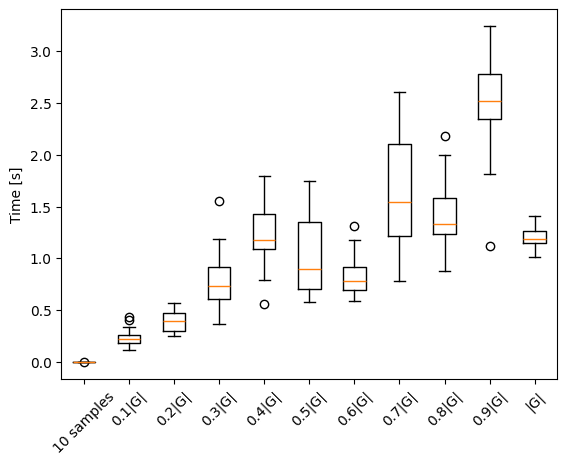

In [34]:
fig, ax1 = plt.subplots()

ax1.boxplot(np.hstack((times_few, times, times_full)))
ax1.set_xticklabels(x_label)
plt.ylabel('Time [s]')
plt.xticks(rotation=45)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(1, 0, '10 samples'),
  Text(2, 0, '0.1|G|'),
  Text(3, 0, '0.2|G|'),
  Text(4, 0, '0.3|G|'),
  Text(5, 0, '0.4|G|'),
  Text(6, 0, '0.5|G|'),
  Text(7, 0, '0.6|G|'),
  Text(8, 0, '0.7|G|'),
  Text(9, 0, '0.8|G|'),
  Text(10, 0, '0.9|G|'),
  Text(11, 0, '|G|')])

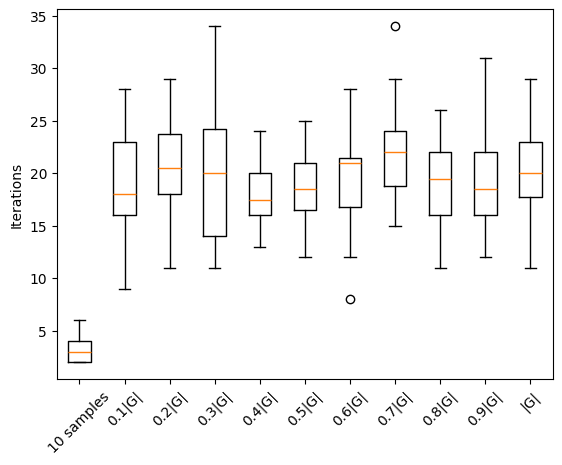

In [35]:
fig, ax1 = plt.subplots()

ax1.boxplot(np.hstack((iters_few, iters, iters_full)))
ax1.set_xticklabels(x_label)
plt.ylabel('Iterations')
plt.xticks(rotation=45)